In [39]:
import pickle
import io
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

CMAP = plt.get_cmap("tab10")

def copy_fig(fig):
    buf = io.BytesIO()
    pickle.dump(fig, buf)
    buf.seek(0)
    return pickle.load(buf)

In [40]:
def f(x):
    return 2 * x * np.sin(x) 

def additive_noise(key, x, sigma):

    key, subkey = jax.random.split(key)

    epsilon = sigma * jax.random.normal(
        key=subkey,
        shape=(x.shape[0], ),
    )

    return key, epsilon

def noisy_f(key, x, sigma):
    key, epsilon = additive_noise(key, x, sigma=sigma)
    y = f(x) + epsilon

    return key, y

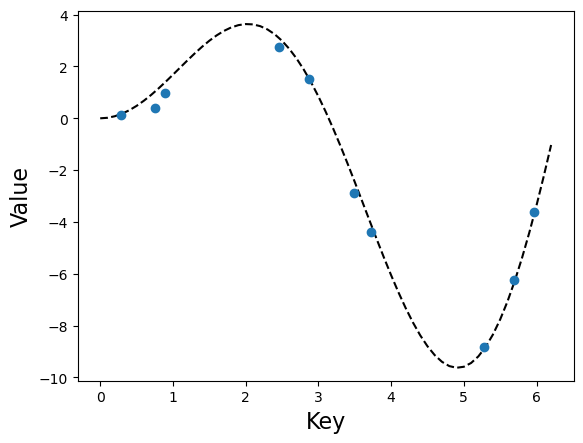

In [46]:
# Constants ====================================================================
seed = 3
N_train = 10
sigma=0.5

key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)

# Ground truth ================================================================
x_gt = jnp.arange(start=0, stop=2 * jnp.pi, step=0.1)
y_gt = f(x_gt)

# Training Data ================================================================
x_train = jax.random.uniform(key=subkey, shape=(N_train, ), minval=0, maxval=2 * jnp.pi)

key, y_train = noisy_f(key, x_train, sigma=sigma)

# Plotting =====================================================================
fig, ax = plt.subplots()
ax.plot(x_gt, y_gt, '--', zorder=1, color="black")
ax.scatter(x_train, y_train, zorder=1, color=CMAP(0))
ylim_min = min(y_gt.min(), y_train.min())
ylim_max = max(y_gt.max(), y_train.max())
ax.set_ylim((ylim_min-0.5, ylim_max+0.5))
ax.set_xlabel("Key", fontsize=16)
ax.set_ylabel("Value", fontsize=16);

In [42]:
def compute_dist(query, key):
    """
    Computes the norm of the distance vector between all elements in the query and key matrices.
    """
    # We have to add a 'dimension' dimension
    # In our case, just 1
    # N_query x D
    query = query[:, jnp.newaxis]

    # N_key x D
    key = key[:, jnp.newaxis]

    # N_query x N_key x D
    dist = query[:, jnp.newaxis] - key[jnp.newaxis, :]

    # N_query x N_key x 1
    dist = jnp.linalg.norm(dist, axis=-1)

    return dist

def log_gaussian_kernel(query, key, sigma: float = 1):
    """
    Computes the Gaussian kernel similarity measure
    """

    dist = compute_dist(query, key)

    # N_query x N_key
    similarity = - 0.5 * jnp.power(dist / sigma, 2)

    return similarity

def attention(query, key, kernel):

    similarity = kernel(query, key)

    attention_weights = jax.nn.softmax(similarity)

    return attention_weights


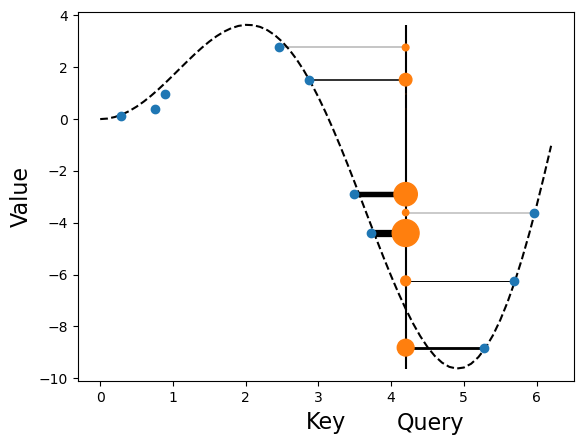

In [61]:
kernel = partial(log_gaussian_kernel, sigma=0.5)

new_point = jnp.array([4.2])

attention_weights = attention(new_point, x_train, kernel)

# Plotting =====================================================================
fig2 = copy_fig(fig)
ax2 = fig2.axes[0]

# Rescale so things lie closer to 1
# Visually retains the idea, but colours don't fade away too quickly
attention_weights_ = jnp.power(attention_weights, 1/2)

# Location of new point as vertical line
ax2.vlines(x=new_point, ymin=ylim_min, ymax=ylim_max, colors=['k'])

ax2.text(x=new_point-0.125, y=-12, s="Query", fontsize=16)

# Contribution of training data as lines and projected circles of varying width
for i, train_point in enumerate(zip(x_train, y_train)):

    ax2.hlines(
        y=train_point[1],
        xmin=min(train_point[0], new_point),
        xmax=max(train_point[0], new_point),
        zorder=0,
        linewidth=[7 * attention_weights_[0][i]],
        colors=["black"]
        )

ax2.scatter(
    x=jnp.tile(new_point, reps=N_train),
    y=y_train,
    s=500 * attention_weights_,
    zorder=2,
    color=CMAP(1),
    alpha=1,
    )

ax.set_xlabel("Key", fontsize=16)
ax.set_ylabel("Value", fontsize=16)

fig2

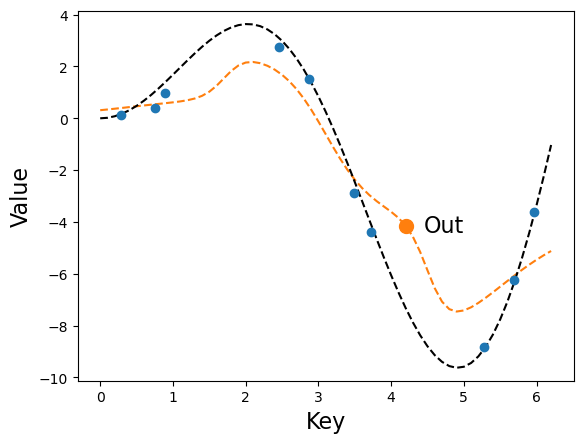

In [69]:
# Plotting =====================================================================
fig3 = copy_fig(fig)
ax3 = fig3.axes[0]

attention_weights = attention(new_point, x_train, kernel=kernel)

# Now plot only the new point
ax3.scatter(
    x=new_point,
    y=(attention_weights * y_train).sum(),
    zorder=2,
    color=CMAP(1),
    s=100,
    )

ax3.text(x=new_point+0.25, y=(attention_weights * y_train).sum(), s="Out", fontsize=16, va="center")

y_pred = (attention(x_gt, x_train, kernel) * y_train).sum(axis=1)
ax3.plot(
    x_gt,
    y_pred,
    zorder=0,
    color=CMAP(1),
    ls='--'
    )

fig3

# Different Kernels

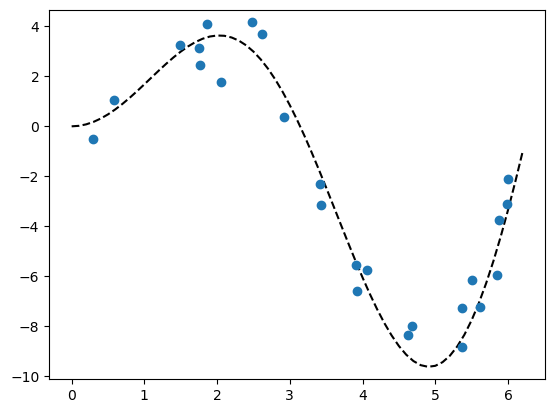

In [72]:
# Constants ====================================================================
seed = 942
N_train = 25
sigma=1.0

key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)

# Ground truth ================================================================
x_gt = jnp.arange(start=0, stop=2 * jnp.pi, step=0.1)
y_gt = f(x_gt)

# Training Data ================================================================
x_train = jax.random.uniform(key=subkey, shape=(N_train, ), minval=0, maxval=2 * jnp.pi)

key, y_train = noisy_f(key, x_train, sigma=sigma)

# Plotting =====================================================================
fig, ax = plt.subplots()
ax.plot(x_gt, y_gt, '--', zorder=1, color="black")
ax.scatter(x_train, y_train, zorder=1, color=CMAP(0))
ylim_min = min(y_gt.min(), y_train.min())
ylim_max = max(y_gt.max(), y_train.max())
ax.set_ylim((ylim_min-0.5, ylim_max+0.5));


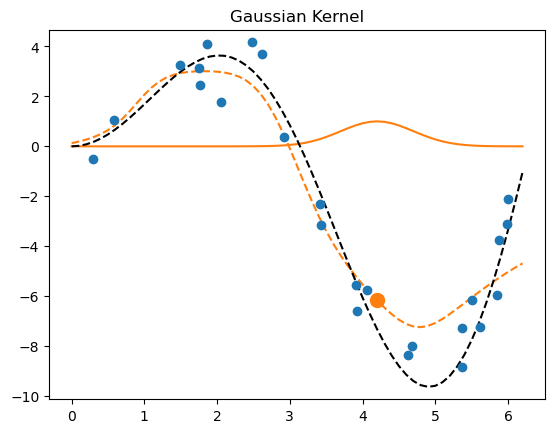

In [73]:
# Plotting =====================================================================
fig4 = copy_fig(fig)
ax4 = fig4.axes[0]

kernel = partial(log_gaussian_kernel, sigma=0.50)

attention_weights = attention(new_point, x_train, kernel=kernel)

# Now plot only the new point
ax4.scatter(
    x=new_point,
    y=(attention_weights * y_train).sum(),
    zorder=2,
    color=CMAP(1),
    s=100,
    )

y_pred = (attention(x_gt, x_train, kernel) * y_train).sum(axis=1)
ax4.plot(
    x_gt,
    y_pred,
    zorder=0,
    color=CMAP(1),
    ls='--'
    )

# Plot the kernel function
kernel_at_new_point = jnp.exp(kernel(new_point, x_gt)).flatten()
kernel_at_new_point = kernel_at_new_point / kernel_at_new_point.max()

ax4.plot(
    x_gt,
    kernel_at_new_point,
    color=CMAP(1),
    zorder=0,
)

ax4.set_title("Gaussian Kernel")

fig4

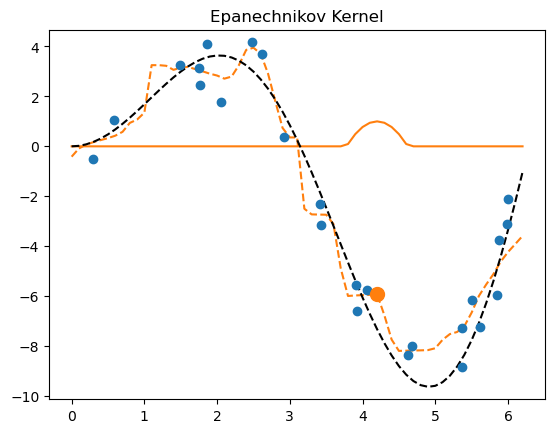

In [84]:
def log_epanechnikov_kernel(query, key, delta: float = 1):
    """
    Computes the Epanechnikov kernel similarity measure
    """

    dist = compute_dist(query, key)
    dist = dist / dist.max(axis=1)[:, jnp.newaxis]

    # N_query x N_key
    similarity = jnp.clip(0.75 * (delta * 1 - jnp.power(dist, 2)), a_min=0)

    return jnp.log(similarity)

# Plotting =====================================================================
fig4 = copy_fig(fig)
ax4 = fig4.axes[0]

kernel = partial(log_epanechnikov_kernel, delta=0.01)

attention_weights = attention(new_point, x_train, kernel=kernel)

# Now plot only the new point
ax4.scatter(
    x=new_point,
    y=(attention_weights * y_train).sum(),
    zorder=2,
    color=CMAP(1),
    s=100,
    )

y_pred = (attention(x_gt, x_train, kernel) * y_train).sum(axis=1)
ax4.plot(
    x_gt,
    y_pred,
    zorder=0,
    color=CMAP(1),
    ls='--'
    )

# Plot the kernel function
kernel_at_new_point = jnp.exp(kernel(new_point, x_gt)).flatten()
kernel_at_new_point = kernel_at_new_point / kernel_at_new_point.max()

ax4.plot(
    x_gt,
    kernel_at_new_point,
    color=CMAP(1),
    zorder=0,
)

ax4.set_title("Epanechnikov Kernel")

fig4

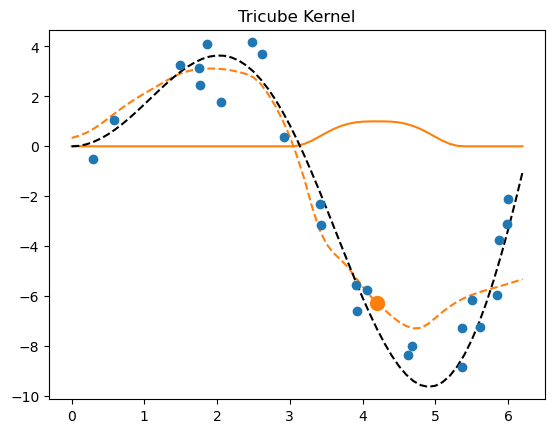

In [86]:
def log_tricube_kernel(query, key, delta: float = 1):
    """
    Computes the Gaussian kernel similarity measure
    """

    dist = compute_dist(query, key)
    dist = dist / dist.max(axis=1)[:, jnp.newaxis]

    # N_query x N_key
    similarity = jnp.clip((70 / 81) * jnp.power((delta * 1 - jnp.power(dist, 3)), 3), a_min=0)

    return jnp.log(similarity)

# Plotting =====================================================================
fig4 = copy_fig(fig)
ax4 = fig4.axes[0]

kernel = partial(log_tricube_kernel, delta=0.025)

attention_weights = attention(new_point, x_train, kernel=kernel)

# Now plot only the new point
ax4.scatter(
    x=new_point,
    y=(attention_weights * y_train).sum(),
    zorder=2,
    color=CMAP(1),
    s=100,
    )

y_pred = (attention(x_gt, x_train, kernel) * y_train).sum(axis=1)
ax4.plot(
    x_gt,
    y_pred,
    zorder=0,
    color=CMAP(1),
    ls='--'
    )

# Plot the kernel function
kernel_at_new_point = jnp.exp(kernel(new_point, x_gt)).flatten()
kernel_at_new_point = kernel_at_new_point / kernel_at_new_point.max()

ax4.plot(
    x_gt,
    kernel_at_new_point,
    color=CMAP(1),
    zorder=0,
)

ax4.set_title("Tricube Kernel")

fig4

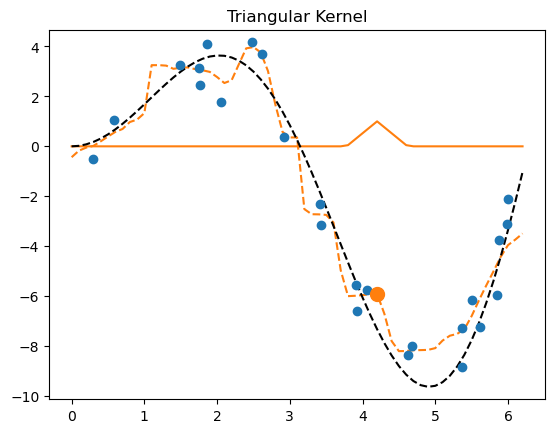

In [91]:
def log_triangular_kernel(query, key, delta: float = 1):
    """
    Computes the Gaussian kernel similarity measure
    """

    dist = compute_dist(query, key)
    dist = dist / dist.max(axis=1)[:, jnp.newaxis]

    # N_query x N_key
    similarity = jnp.clip(delta - dist, a_min=1e-9)

    return jnp.log(similarity)

# Plotting =====================================================================
fig4 = copy_fig(fig)
ax4 = fig4.axes[0]

kernel = partial(log_triangular_kernel, delta=0.1)

attention_weights = attention(new_point, x_train, kernel=kernel)

# Now plot only the new point
ax4.scatter(
    x=new_point,
    y=(attention_weights * y_train).sum(),
    zorder=2,
    color=CMAP(1),
    s=100,
    )

y_pred = (attention(x_gt, x_train, kernel) * y_train).sum(axis=1)
ax4.plot(
    x_gt,
    y_pred,
    zorder=0,
    color=CMAP(1),
    ls='--'
    )

# Plot the kernel function
kernel_at_new_point = jnp.exp(kernel(new_point, x_gt)).flatten()
kernel_at_new_point = kernel_at_new_point / kernel_at_new_point.max()

ax4.plot(
    x_gt,
    kernel_at_new_point,
    color=CMAP(1),
    zorder=0,
)

ax4.set_title("Triangular Kernel")

fig4